In [1]:
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, LeakyReLU
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Preprocessing

In [2]:
TRAIN_START_DATE = '1960-01-01'
TRAIN_END_DATE = '2015-12-31'
PREDICT_START_DATE = '2016-01-01'
PREDICT_END_DATE = '2019-12-31'
WINDOW_SIZE = 7

In [3]:
# Download S&P 500 data from Yahoo Finance
df = yf.download('^GSPC', start=TRAIN_START_DATE, end=PREDICT_END_DATE)

df = df.reset_index()

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = df['Date'].apply(str_to_datetime)

df.index = df.pop('Date')

# Drop columns that are not needed
df = df.drop(columns=['Adj Close'])

[*********************100%***********************]  1 of 1 completed


In [4]:
# Split data into train and test sets
X_train = df[:PREDICT_START_DATE]
X_test = df[PREDICT_START_DATE:PREDICT_END_DATE]

y_train = X_train.pop('Close')
y_test = X_test.pop('Close')

In [5]:
def df_to_windowed_df(feature, df, window_size, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE):
    """Converts a dataframe into a windowed dataframe and date list"""
    df = df[start_date:end_date]
    date_list = df.index.to_list()
    feature_values = df[feature].to_numpy()
    windowed_df = []
    for i in range(len(feature_values) - window_size):
        windowed_df.append(feature_values[i:i+window_size])
    return np.array(windowed_df), date_list[window_size:]

# Create windowed dataframes and date_list
open_windowed_df, date_list = df_to_windowed_df('Open', df, window_size=WINDOW_SIZE, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE)
high_windowed_df, date_list = df_to_windowed_df('High', df, window_size=WINDOW_SIZE, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE)
low_windowed_df, date_list = df_to_windowed_df('Low', df, window_size=WINDOW_SIZE, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE)
volume_windowed_df, date_list = df_to_windowed_df('Volume', df, window_size=WINDOW_SIZE, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE)

In [6]:
to_combine_open_windowed_df, _ = df_to_windowed_df('Open', df, window_size=1, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE)
to_combine_high_windowed_df, _ = df_to_windowed_df('High', df, window_size=1, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE)
to_combine_low_windowed_df, _ = df_to_windowed_df('Low', df, window_size=1, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE)
to_combine_volume_windowed_df, _ = df_to_windowed_df('Volume', df, window_size=1, start_date=PREDICT_START_DATE, end_date=PREDICT_END_DATE)

# Stack the windowed dataframes along the third axis
stacked_windowed_df = np.stack([open_windowed_df, high_windowed_df, low_windowed_df, volume_windowed_df], axis=-1)

# Reshape the stacked_windowed_df into the desired shape (975, 30, 4)
combined_windowed_df = stacked_windowed_df.reshape((-1, WINDOW_SIZE, 4))

In [7]:
def windowed_df_to_date_X_y(windowed_df, date_list):
    """Converts a windowed dataframe and date list into a date, X, and y dataframe"""
    date_df = []
    X_df = []
    y_df = []
    for i in range(len(windowed_df) - 1):  # Modify the range to exclude the last window
        date_df.append(date_list[i + 1])   # Shift date by 1
        X_df.append(windowed_df[i])
        if windowed_df.ndim == 3:
            y_df.append(windowed_df[i + 1][-1][-1])  # Shift the target y value by 1 (for 3D input)
        else:
            y_df.append(windowed_df[i + 1][-1])  # Shift the target y value by 1 (for 2D input)
    return np.array(date_df), np.array(X_df), np.array(y_df)

# Use the modified function with the date_list parameter
date_df, X_open, y_open = windowed_df_to_date_X_y(open_windowed_df, date_list)
_, X_high, y_high = windowed_df_to_date_X_y(high_windowed_df, date_list)
_, X_low, y_low = windowed_df_to_date_X_y(low_windowed_df, date_list)
_, X_volume, y_volume = windowed_df_to_date_X_y(volume_windowed_df, date_list)
_, X_train_combined, _ = windowed_df_to_date_X_y(combined_windowed_df, date_list)
y_train_combined = y_train[len(y_train) - len(X_train_combined):].to_numpy()

# Model 2

In [8]:
class CreateModel:
    def __init__(self, feature, dates, X_train, y_train, window_size, params=None):
        self.feature = feature
        self.dates = dates
        self.X = X_train    
        self.y = y_train
        self.window_size = window_size
        self.params = params

        if self.params is None:
            self.best_model = self.train_model(True)
        else:
            self.best_model = self.train_model(False)

    def create_model(self, lstm_units=64, dense_units=32, learning_rate=0.001, lstm_activation='tanh', dense_activation='relu'):
        model = Sequential([
            Input((self.window_size, 1)),
            LSTM(lstm_units, activation=lstm_activation),
        ])

        if dense_activation == 'leaky_relu':
            model.add(Dense(dense_units))
            model.add(LeakyReLU(alpha=0.3))
            model.add(Dense(dense_units))
            model.add(LeakyReLU(alpha=0.3))
        else:
            model.add(Dense(dense_units, activation=dense_activation))
            model.add(Dense(dense_units, activation=dense_activation))
            model.add(Dense(1))

        model.compile(loss='mse',
                    optimizer=Adam(learning_rate=learning_rate),
                    metrics=['mean_absolute_error'])

        return model

    def train_model(self, grid_search):
        # Check if GPU is available
        if tf.config.list_physical_devices('GPU'):
            print("Using GPU")
            # Set the device to GPU:0
            with tf.device('/GPU:0'):
                best_model = self.train_model_helper(grid_search)
        else:
            print("Using CPU")
            # If GPU is not available, perform grid search on CPU
            best_model = self.train_model_helper(grid_search)

        return best_model

    def train_model_helper(self, grid_search):
        # Wrap the create_model function with KerasRegressor
        model = KerasRegressor(build_fn=self.create_model, verbose=1)

        # Define the grid search parameters
        param_grid = {
            'lstm_units': [8, 16],
            'dense_units': [4, 8],
            'learning_rate': [0.0001, 0.0005],
            'epochs': [30, 50],
            'batch_size': [8, 16],
            'lstm_activation': ['tanh', 'relu'],
            'dense_activation': ['relu', 'elu']
        }

        # Create the GridSearchCV object
        grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=6, cv=3, verbose=1)

        # Split the data into training and validation
        q_80 = int(len(self.dates) * .8)

        self.dates_train, X_train, y_train = self.dates[:q_80], self.X[:q_80], self.y[:q_80]
        self.dates_val, X_val, y_val = self.dates[q_80:], self.X[q_80:], self.y[q_80:]

        # Flatten the training data for GridSearchCV
        X_train_flat = np.reshape(X_train, (X_train.shape[0], -1))
        y_train_flat = y_train.flatten()
        
        if grid_search:
            # Perform grid search
            grid_result = grid.fit(X_train_flat, y_train_flat)

            # Print the best hyperparameters
            print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

            # Create a model with the best hyperparameters
            best_params = grid_result.best_params_

            # Save the best hyperparameters
            best_params_df = pd.DataFrame(best_params, index=[0])
            best_params_df.to_csv(f'{self.feature}_best_params.csv', index=False)

            best_epochs = best_params.pop('epochs')
            best_batch_size = best_params.pop('batch_size')
            best_model = self.create_model(**best_params)
        else:
            print("Using best hyperparameters from previous run")
            best_epochs = self.params.pop('epochs')
            best_batch_size = self.params.pop('batch_size')
            best_model = self.create_model(**self.params)

        # Train the best model with the training data using default batch_size and epochs
        best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_epochs, batch_size=best_batch_size)

        return best_model

    def predict(self):
        train_predictions = self.best_model.predict(self.X).flatten()
        return train_predictions

    def plot(self):
        plt.figure(figsize=(20, 10))
        plt.plot(self.dates, self.y, label='Actual')
        plt.plot(self.dates, self.predict(), label='Predicted')
        plt.legend()

## Only run when you're want to grid search

In [9]:
# print("Creating Open Model")
# open_model = CreateModel('Open', df, START_DATE, END_DATE, n=3)
# print("Creating High Model")
# high_model = CreateModel('High', df, START_DATE, END_DATE, n=3)
# print("Creating Low Model")
# low_model = CreateModel('Low', df, START_DATE, END_DATE, n=3)
# print("Creating Volume Model")
# volume_model = CreateModel('Volume', df, START_DATE, END_DATE, n=3)
# print("Done")

## Only Run if you want to train and save the models

In [10]:
open_params = pd.read_csv('Open_best_params.csv').to_dict(orient='records')[0]
open_model = CreateModel('Open', date_df, X_open, y_open, WINDOW_SIZE, params=open_params)

Using GPU
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Using best hyperparameters from previous run


2023-04-25 12:15:04.695658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
/var/folders/3g/0l7bk23d0116yj_4z59psh_c0000gn/T/ipykernel_45034/2030118360.py:53: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=self.create_model, verbose=1)
2023-04-25 12:15:04.696247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2023-04-25 12:15:04.962459: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-25 12:15:05.424463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 5483067.5000 - mean_absolute_error: 2325.1443

2023-04-25 12:15:14.715924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 10s 94ms/step - loss: 5483067.5000 - mean_absolute_error: 2325.1443 - val_loss: 6851913.0000 - val_mean_absolute_error: 2615.9197
Epoch 2/50
100/100 [==============================] - 8s 81ms/step - loss: 3583192.7500 - mean_absolute_error: 1867.9003 - val_loss: 2978884.5000 - val_mean_absolute_error: 1724.7671
Epoch 3/50
100/100 [==============================] - 7s 69ms/step - loss: 799103.8125 - mean_absolute_error: 815.9459 - val_loss: 96815.7500 - val_mean_absolute_error: 310.3407
Epoch 4/50
100/100 [==============================] - 7s 69ms/step - loss: 10013.3652 - mean_absolute_error: 70.9700 - val_loss: 403.2665 - val_mean_absolute_error: 15.5858
Epoch 5/50
100/100 [==============================] - 8s 76ms/step - loss: 367.6480 - mean_absolute_error: 12.6443 - val_loss: 402.6380 - val_mean_absolute_error: 15.5610
Epoch 6/50
100/100 [==============================] - 7s 74ms/step - loss: 366.6191 - mean_absolute_error: 12.5934 - val_l

 6/32 [====>.........................] - ETA: 0s

2023-04-25 12:20:51.693184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


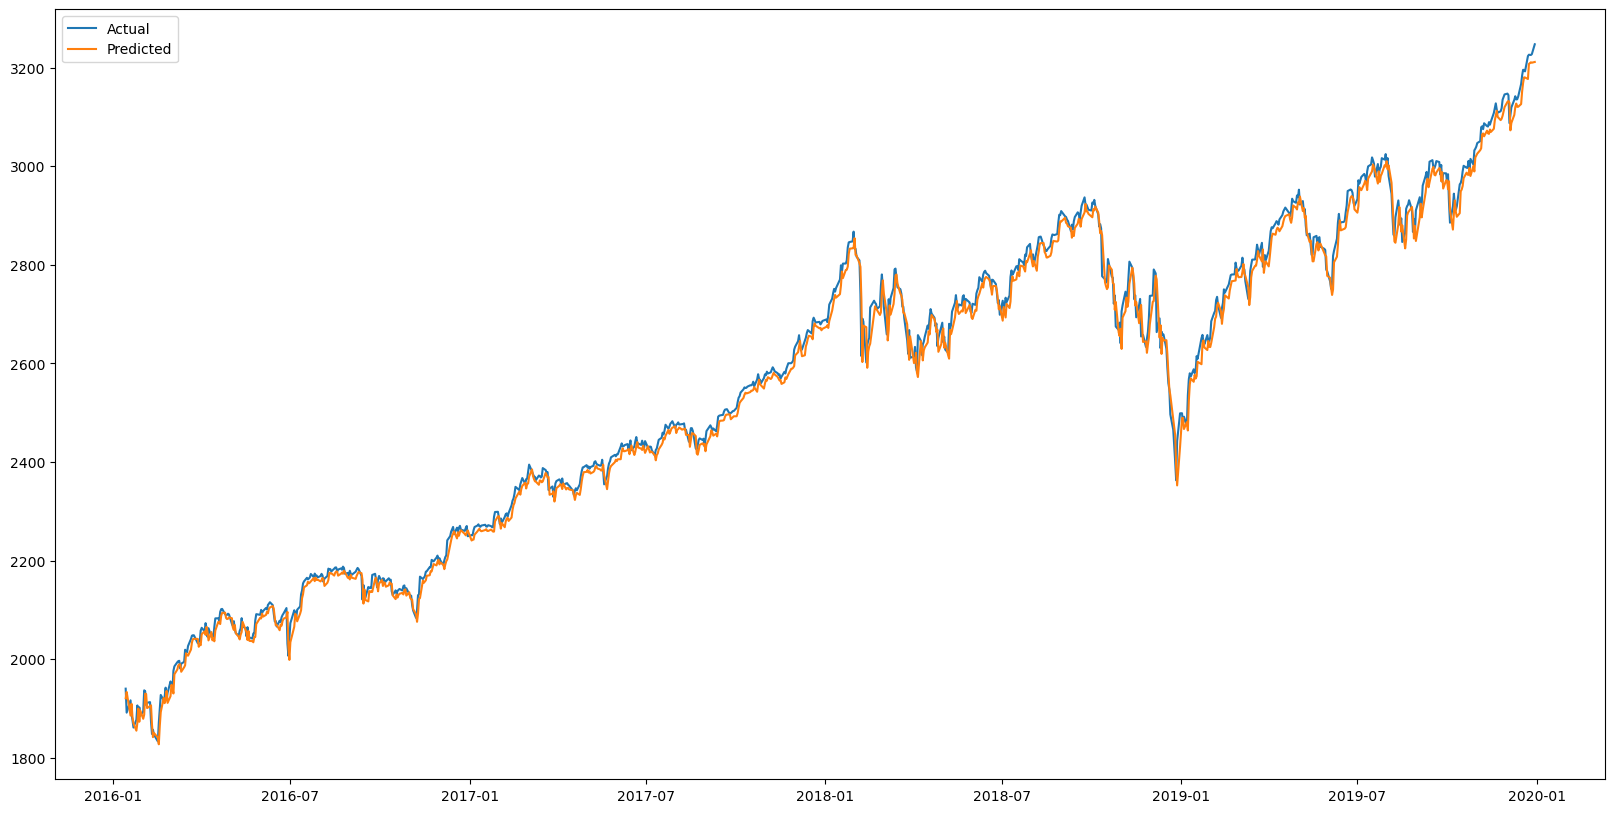

In [11]:
open_model.plot()

In [12]:
open_model.best_model.save('open_model.h5')

In [13]:
high_params = pd.read_csv('High_best_params.csv').to_dict(orient='records')[0]
high_model = CreateModel('High', date_df, X_high, y_high, WINDOW_SIZE, params=high_params)

Using GPU
Using best hyperparameters from previous run
Epoch 1/50


/var/folders/3g/0l7bk23d0116yj_4z59psh_c0000gn/T/ipykernel_45034/2030118360.py:53: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=self.create_model, verbose=1)
2023-04-25 12:20:52.851571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 3711037.2500 - mean_absolute_error: 1909.5847

2023-04-25 12:20:59.483682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 7s 67ms/step - loss: 3711037.2500 - mean_absolute_error: 1909.5847 - val_loss: 4118583.2500 - val_mean_absolute_error: 2028.0514
Epoch 2/50
100/100 [==============================] - 6s 64ms/step - loss: 2214864.2500 - mean_absolute_error: 1473.4862 - val_loss: 2254863.7500 - val_mean_absolute_error: 1500.4709
Epoch 3/50
100/100 [==============================] - 6s 64ms/step - loss: 984395.5625 - mean_absolute_error: 973.0182 - val_loss: 700081.6875 - val_mean_absolute_error: 835.6111
Epoch 4/50
100/100 [==============================] - 6s 64ms/step - loss: 218180.8906 - mean_absolute_error: 443.6002 - val_loss: 79088.0781 - val_mean_absolute_error: 279.1230
Epoch 5/50
100/100 [==============================] - 6s 64ms/step - loss: 16411.5586 - mean_absolute_error: 109.2206 - val_loss: 2526.1836 - val_mean_absolute_error: 44.0513
Epoch 6/50
100/100 [==============================] - 6s 64ms/step - loss: 1077.5104 - mean_absolute_error: 24.42

10/32 [========>.....................] - ETA: 0s

2023-04-25 12:26:16.207923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


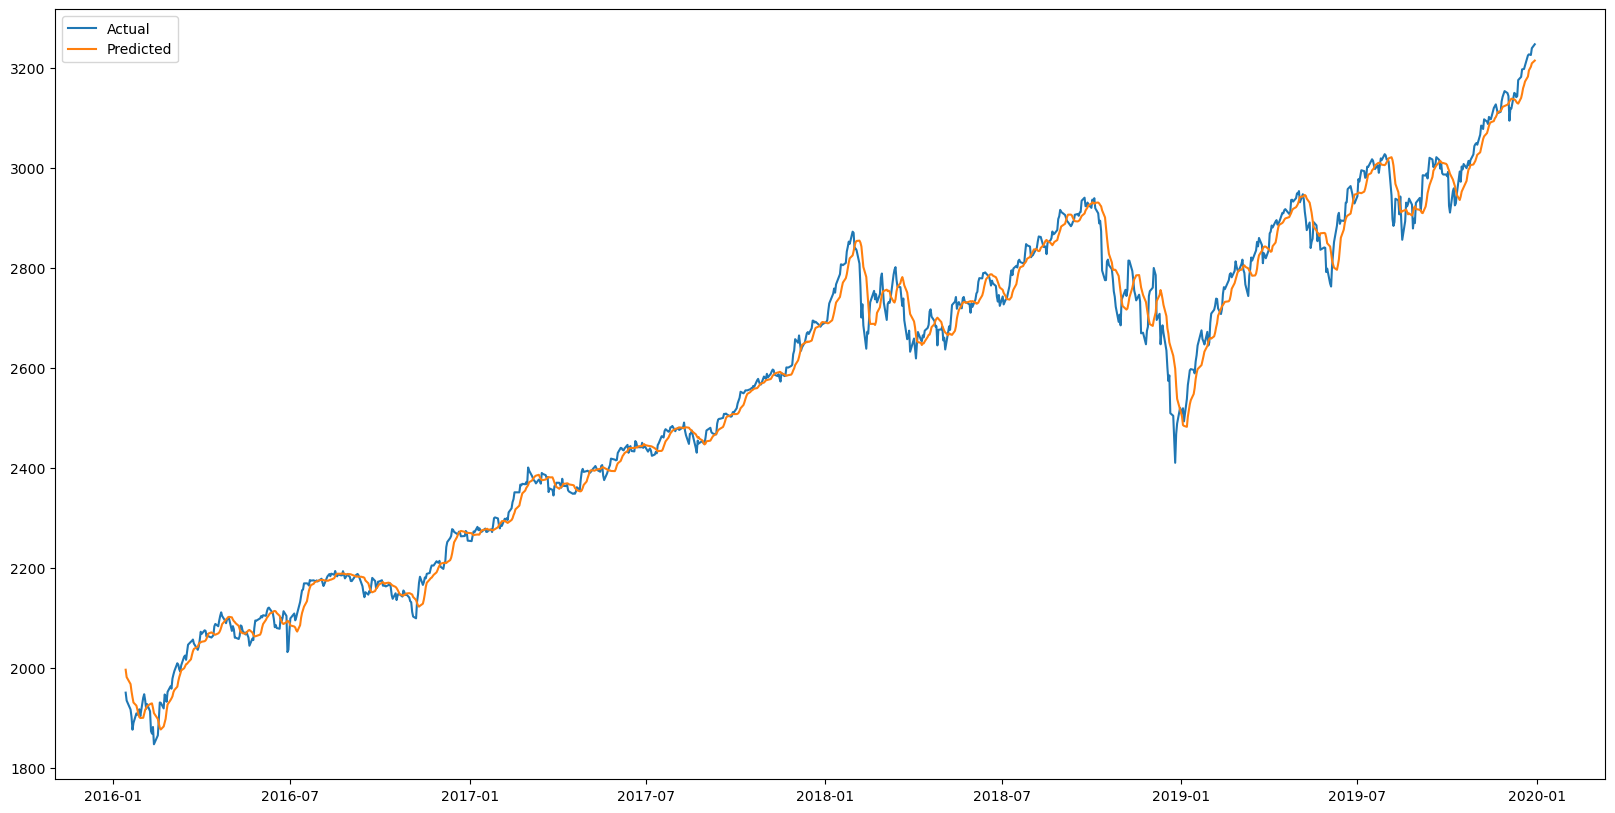

In [14]:
high_model.plot()

In [15]:
high_model.best_model.save('high_model.h5')

In [16]:
low_params = pd.read_csv('Low_best_params.csv').to_dict(orient='records')[0]
low_model = CreateModel('Low', date_df, X_low, y_low, WINDOW_SIZE, params=low_params)

Using GPU
Using best hyperparameters from previous run
Epoch 1/50


/var/folders/3g/0l7bk23d0116yj_4z59psh_c0000gn/T/ipykernel_45034/2030118360.py:53: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=self.create_model, verbose=1)
2023-04-25 12:26:17.313012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 7724739.0000 - mean_absolute_error: 2760.2910

2023-04-25 12:26:24.780905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 8s 76ms/step - loss: 7724739.0000 - mean_absolute_error: 2760.2910 - val_loss: 10664765.0000 - val_mean_absolute_error: 3263.4927
Epoch 2/50
100/100 [==============================] - 7s 69ms/step - loss: 7003752.5000 - mean_absolute_error: 2628.9006 - val_loss: 10146979.0000 - val_mean_absolute_error: 3183.2957
Epoch 3/50
100/100 [==============================] - 8s 75ms/step - loss: 6867271.5000 - mean_absolute_error: 2603.1819 - val_loss: 9759163.0000 - val_mean_absolute_error: 3121.8474
Epoch 4/50
100/100 [==============================] - 7s 72ms/step - loss: 6671793.5000 - mean_absolute_error: 2565.8792 - val_loss: 9546129.0000 - val_mean_absolute_error: 3087.5820
Epoch 5/50
100/100 [==============================] - 7s 72ms/step - loss: 6545790.0000 - mean_absolute_error: 2541.5198 - val_loss: 9389773.0000 - val_mean_absolute_error: 3062.1909
Epoch 6/50
100/100 [==============================] - 7s 73ms/step - loss: 6449899.5000 - mean

 5/32 [===>..........................] - ETA: 0s

2023-04-25 12:32:15.771597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


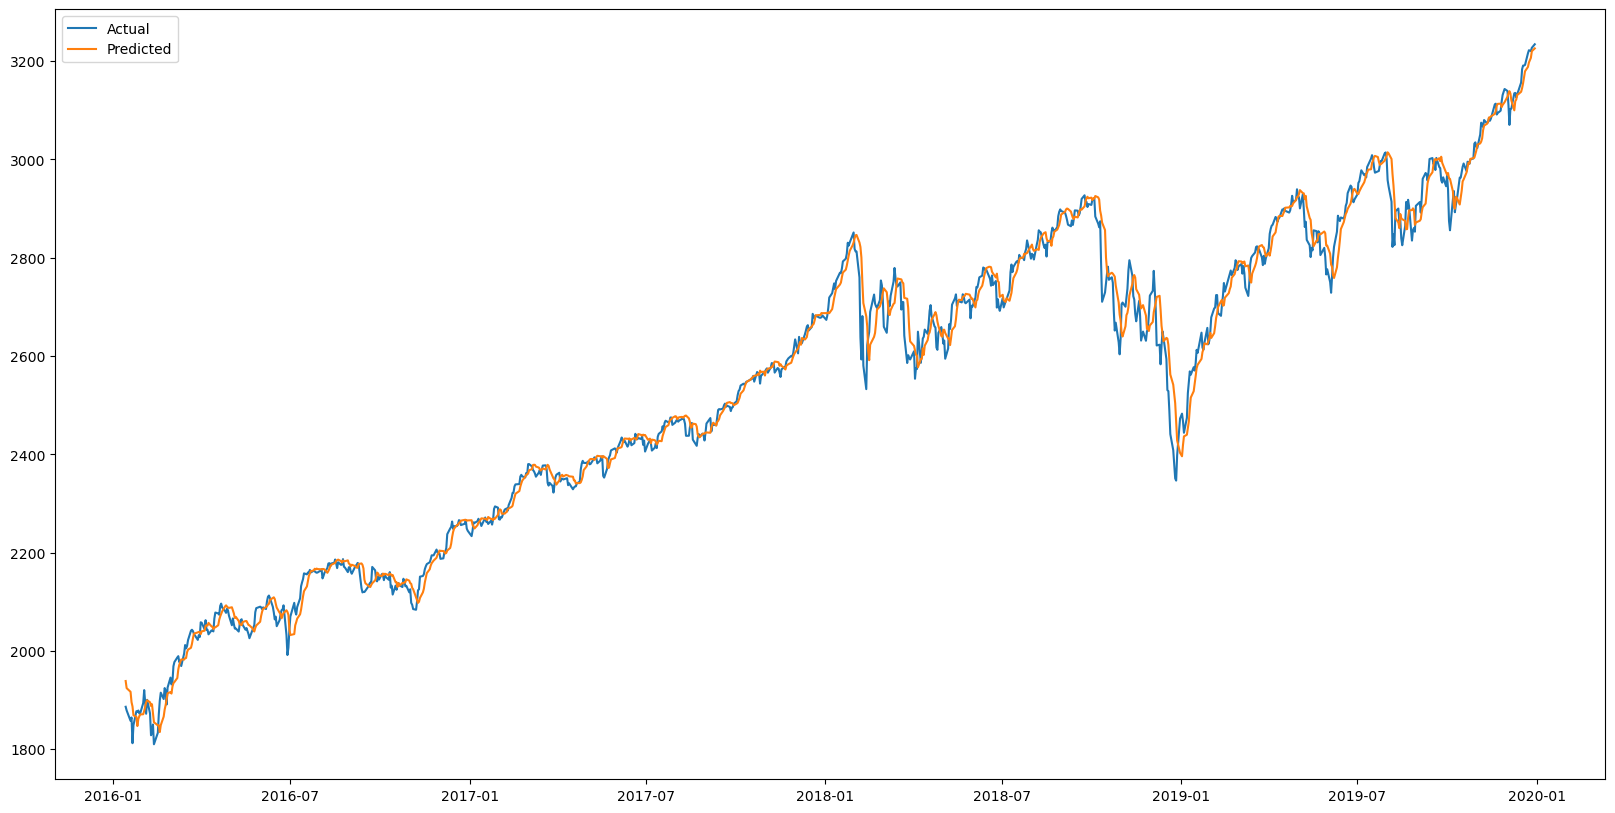

In [17]:
low_model.plot()

In [18]:
low_model.best_model.save('low_model.h5')

In [20]:
volume_params = pd.read_csv('Volume_best_params.csv').to_dict(orient='records')[0]
volume_model = CreateModel('Volume', date_df, X_volume, y_volume, WINDOW_SIZE, params=volume_params)

Using GPU
Using best hyperparameters from previous run
Epoch 1/30


/var/folders/3g/0l7bk23d0116yj_4z59psh_c0000gn/T/ipykernel_45034/2030118360.py:53: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=self.create_model, verbose=1)
2023-04-25 12:36:45.016139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 2819380910082752512.0000 - mean_absolute_error: 1327496832.0000

2023-04-25 12:36:52.342787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 8s 74ms/step - loss: 2819380910082752512.0000 - mean_absolute_error: 1327496832.0000 - val_loss: 2421107012176707584.0000 - val_mean_absolute_error: 1144754432.0000
Epoch 2/30
100/100 [==============================] - 7s 68ms/step - loss: 2178056943199846400.0000 - mean_absolute_error: 1018686144.0000 - val_loss: 2059615351632560128.0000 - val_mean_absolute_error: 949286080.0000
Epoch 3/30
100/100 [==============================] - 7s 68ms/step - loss: 1867119590350258176.0000 - mean_absolute_error: 878868608.0000 - val_loss: 1907703526604144640.0000 - val_mean_absolute_error: 901723008.0000
Epoch 4/30
100/100 [==============================] - 7s 67ms/step - loss: 1709523839962054656.0000 - mean_absolute_error: 845146176.0000 - val_loss: 1882694035118751744.0000 - val_mean_absolute_error: 905386688.0000
Epoch 5/30
100/100 [==============================] - 7s 66ms/step - loss: 1660694253694615552.0000 - mean_absolute_error: 842530304.0000 - 

 5/32 [===>..........................] - ETA: 0s

2023-04-25 12:40:07.520112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


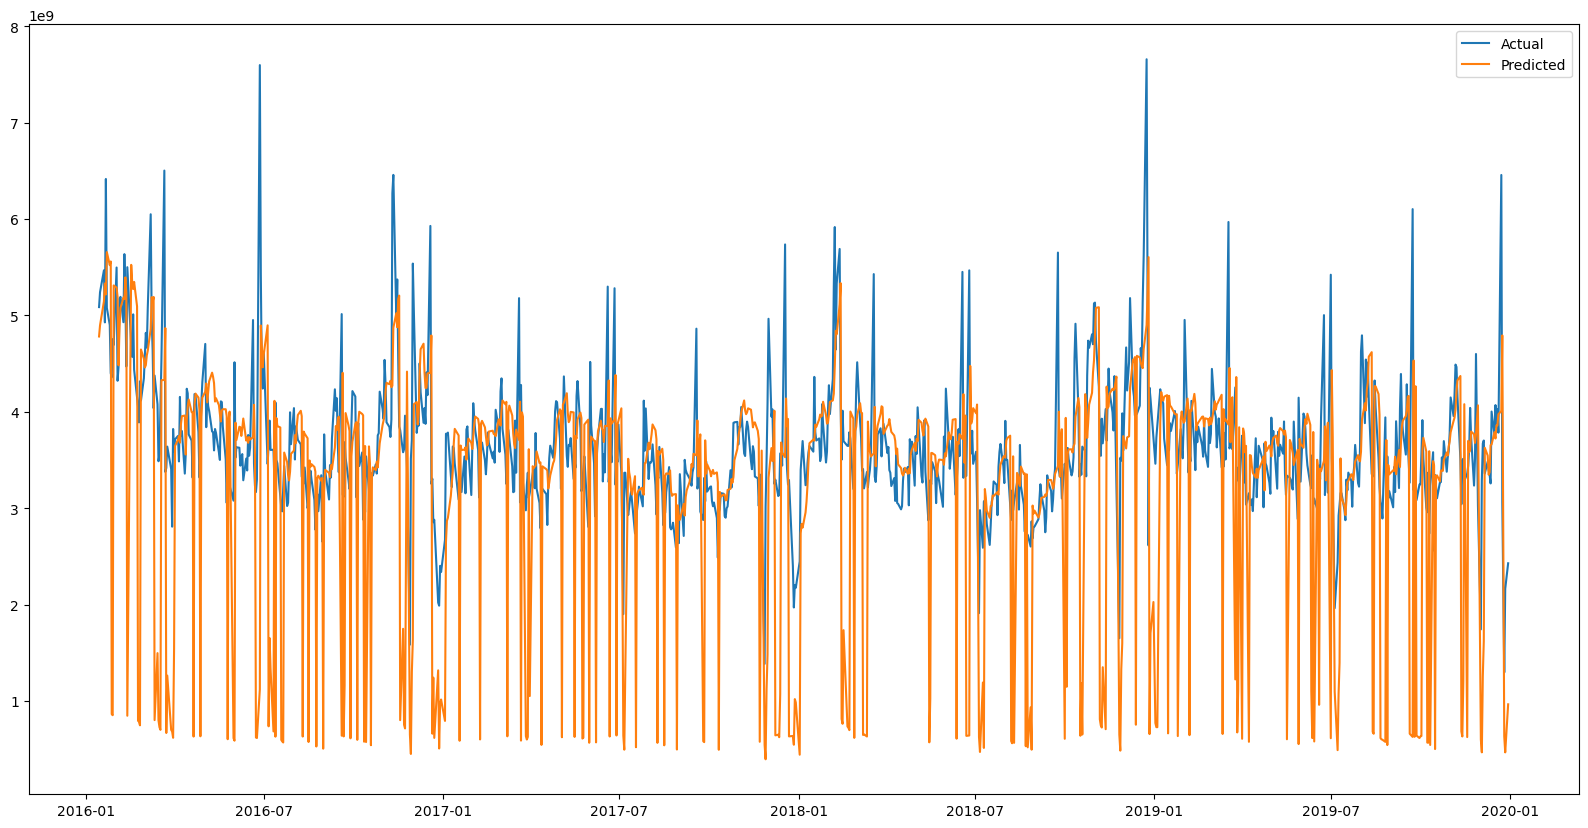

In [21]:
volume_model.plot()

In [22]:
volume_model.best_model.save('volume_model.h5')

## Restore models
You have to run this even when you're training

In [23]:
open_model = tf.keras.models.load_model('open_model.h5')
high_model = tf.keras.models.load_model('high_model.h5')
low_model = tf.keras.models.load_model('low_model.h5')
volume_model = tf.keras.models.load_model('volume_model.h5')

## Plot Restored Model

 9/32 [=======>......................] - ETA: 0s

2023-04-25 12:40:08.791756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


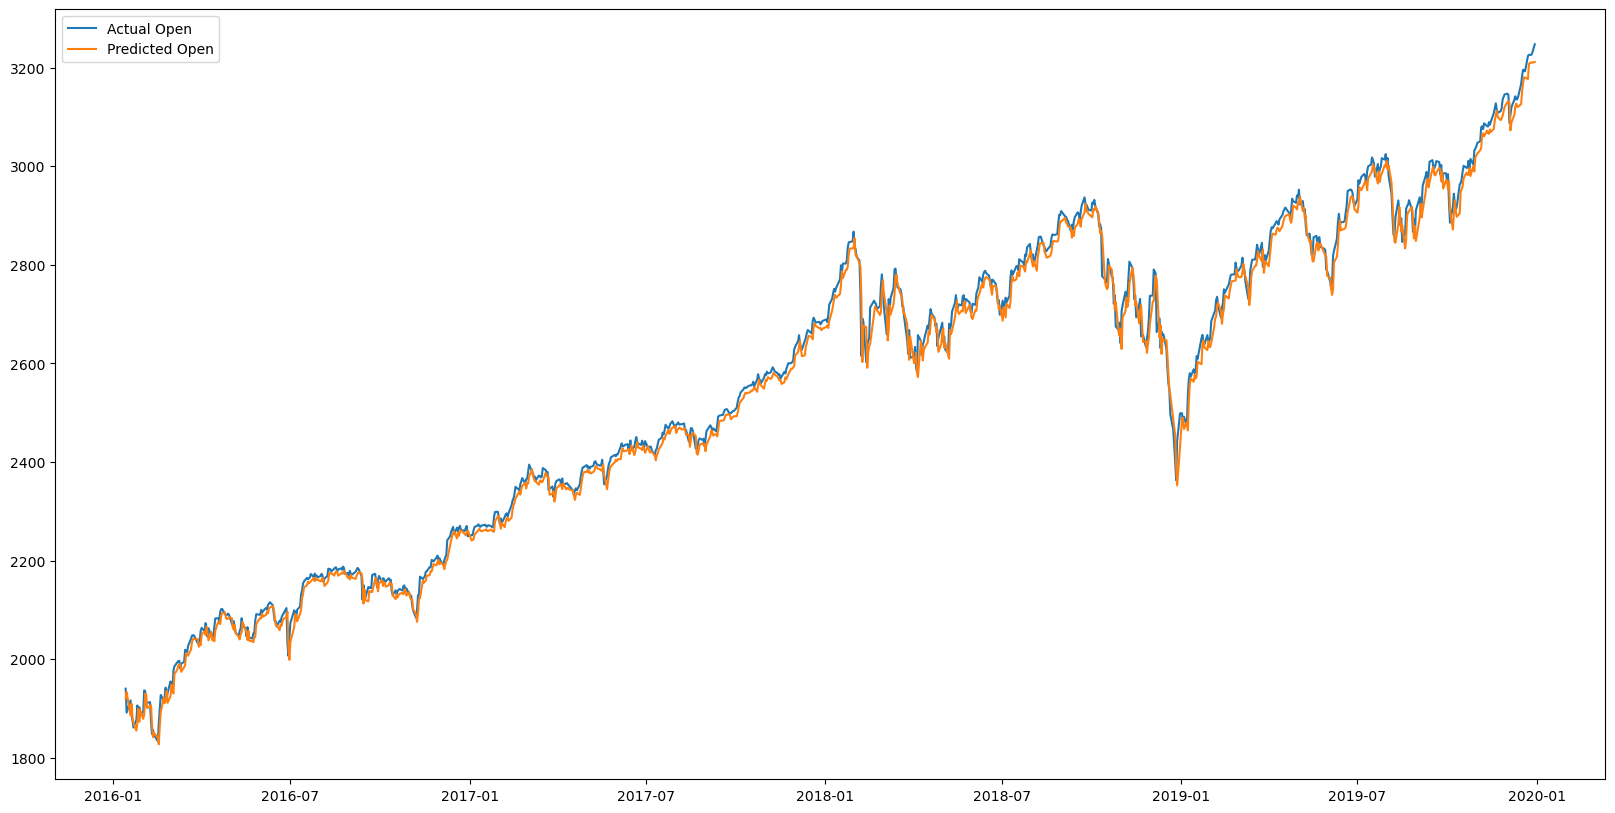

In [24]:
# Plot the preidction and actual values
plt.figure(figsize=(20, 10))
plt.plot(date_df, y_open, label='Actual Open')
plt.plot(date_df, open_model.predict(X_open), label='Predicted Open')
plt.legend()

11/32 [=========>....................] - ETA: 0s

2023-04-25 12:40:09.550603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


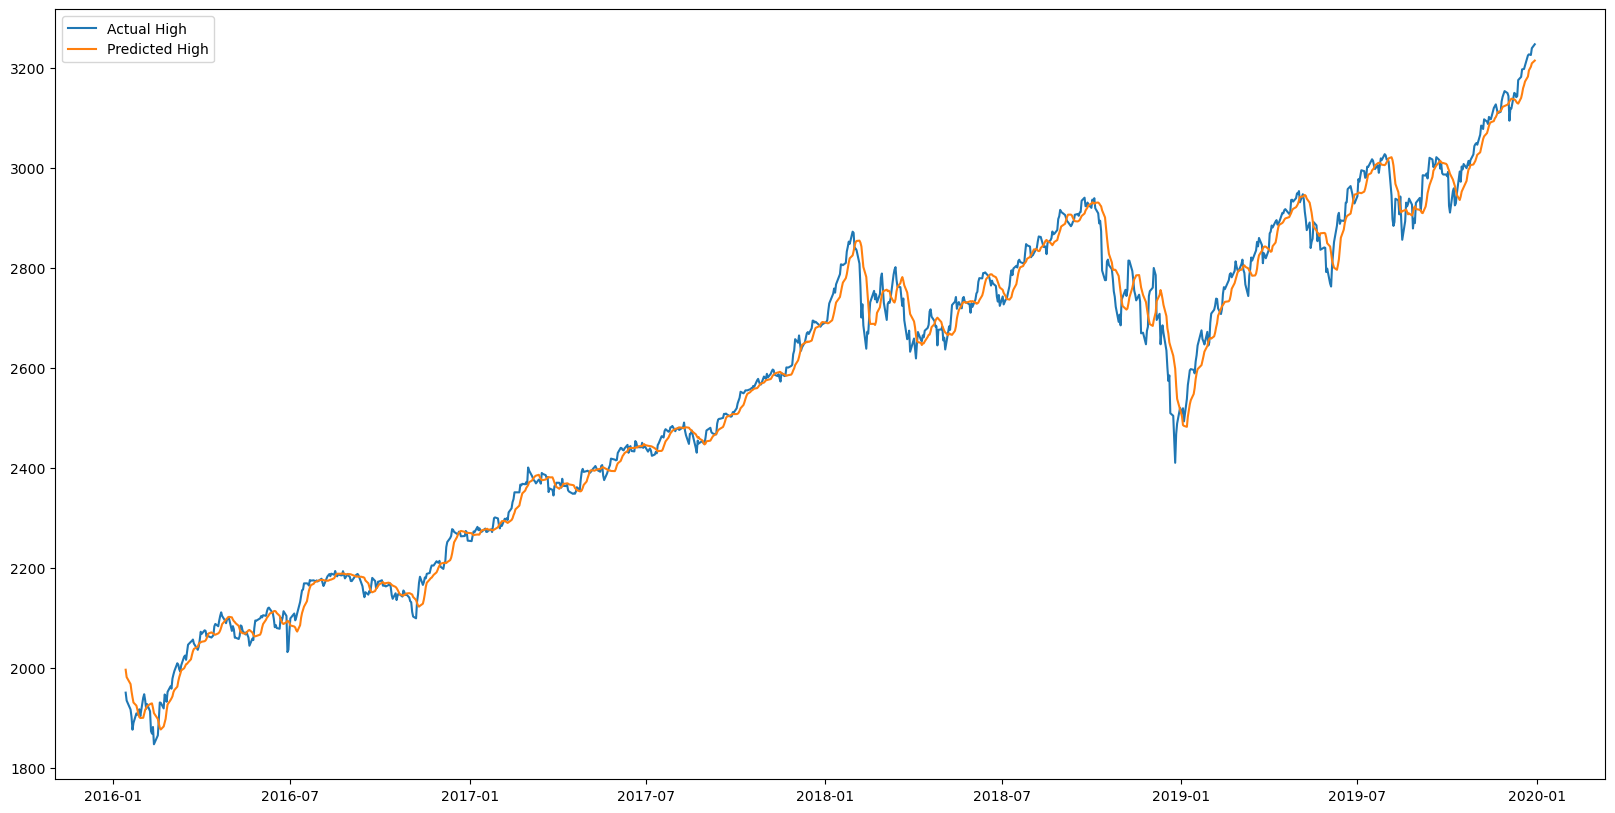

In [25]:
# Plot the preidction and actual values
plt.figure(figsize=(20, 10))
plt.plot(date_df, y_high, label='Actual High')
plt.plot(date_df, high_model.predict(X_high), label='Predicted High')
plt.legend()

10/32 [========>.....................] - ETA: 0s

2023-04-25 12:40:10.288028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step


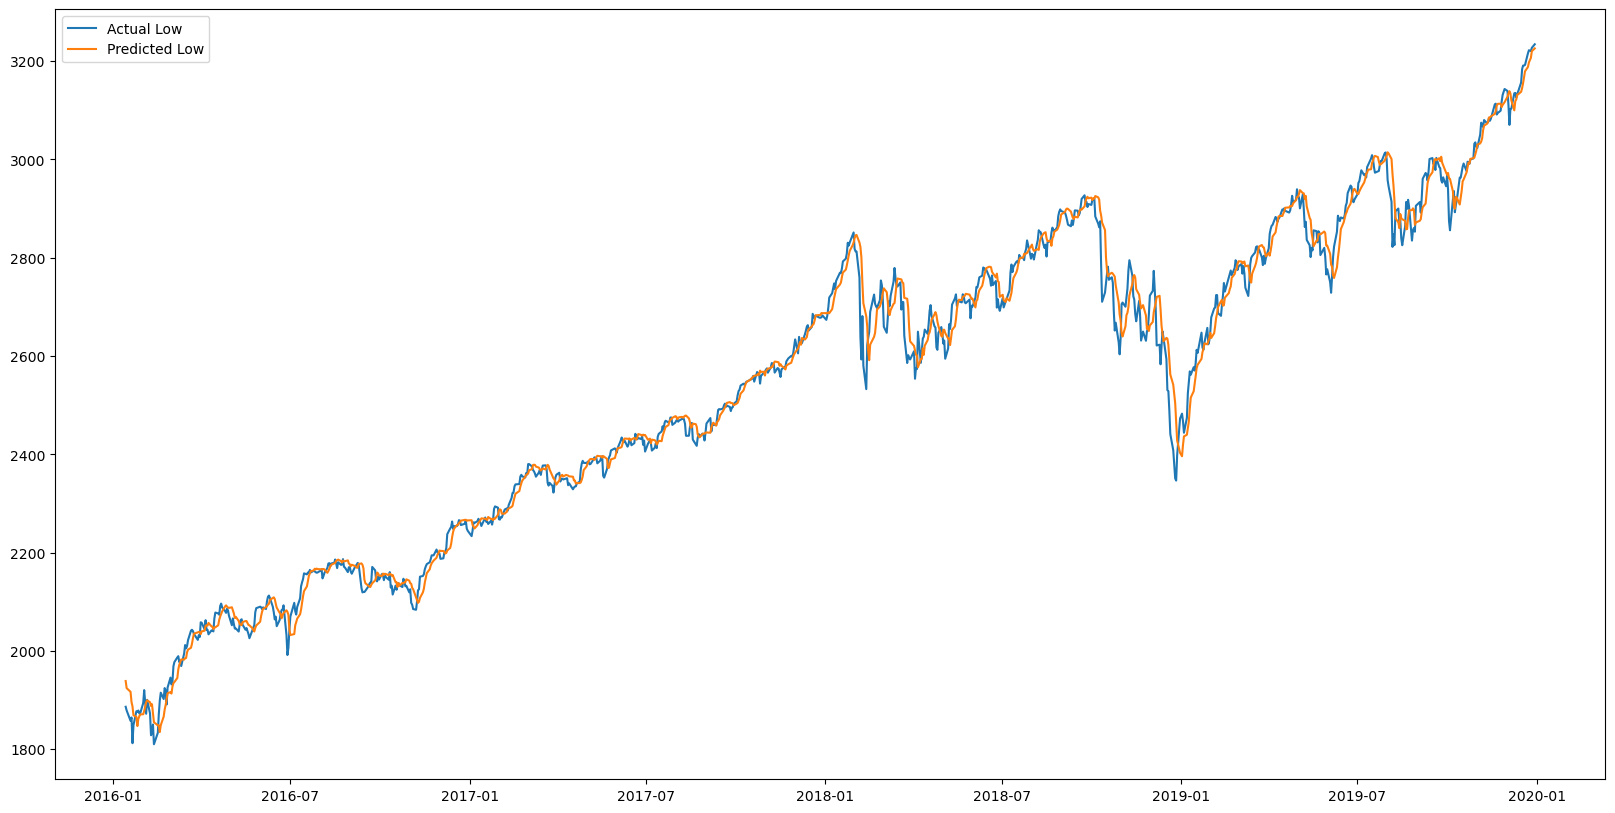

In [26]:
# Plot the preidction and actual values
plt.figure(figsize=(20, 10))
plt.plot(date_df, y_low, label='Actual Low')
plt.plot(date_df, low_model.predict(X_low), label='Predicted Low')
plt.legend()

10/32 [========>.....................] - ETA: 0s

2023-04-25 12:40:11.010772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


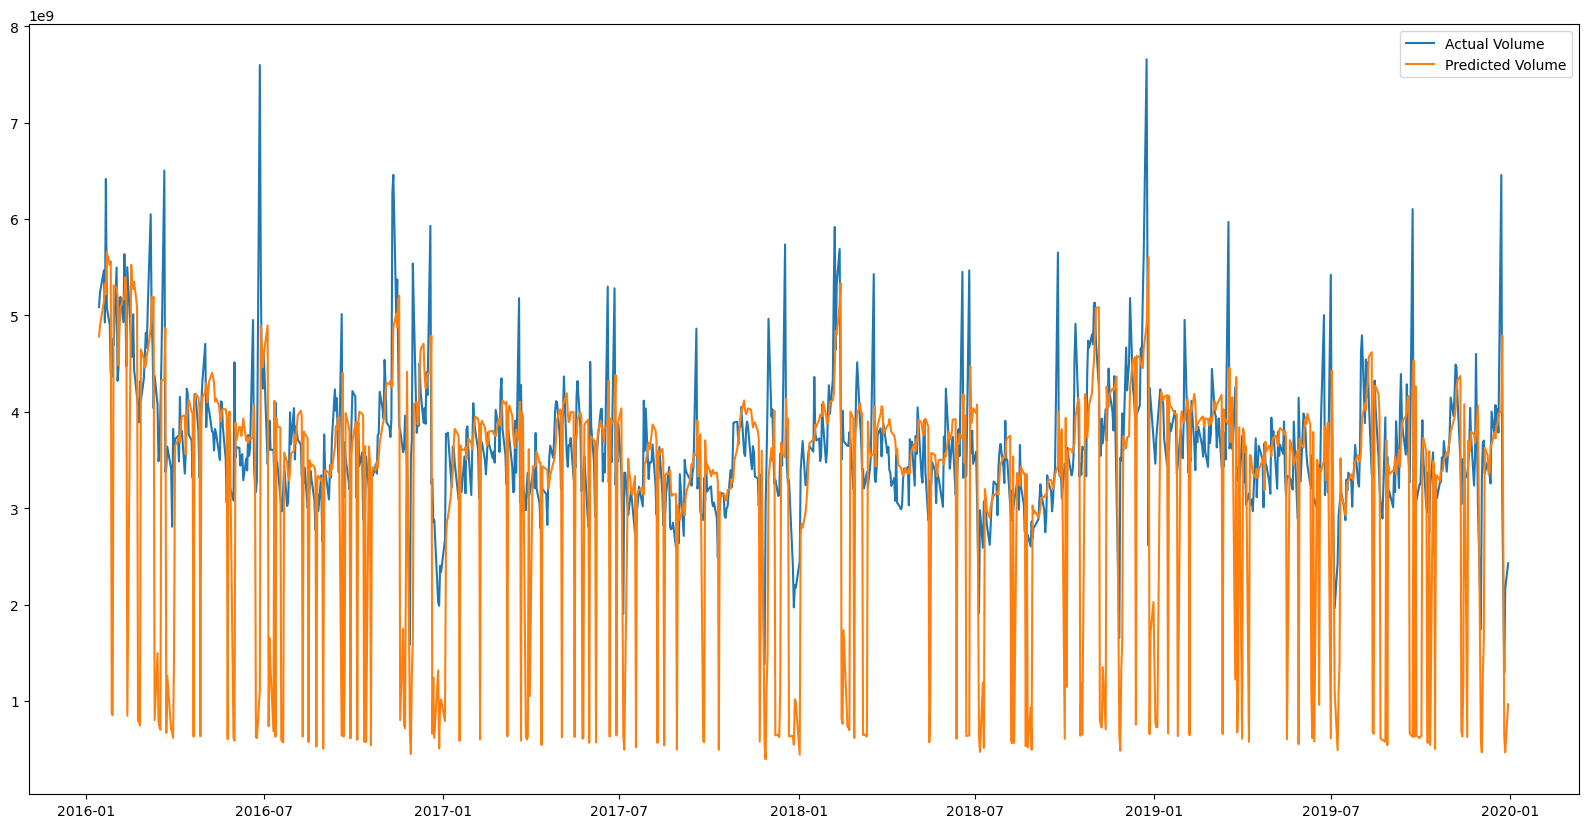

In [27]:
# Plot the preidction and actual values
plt.figure(figsize=(20, 10))
plt.plot(date_df, y_volume, label='Actual Volume')
plt.plot(date_df, volume_model.predict(X_volume), label='Predicted Volume')
plt.legend()